<a href="https://colab.research.google.com/github/lulislarr/curso_deep_learning/blob/main/first_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision.all import *

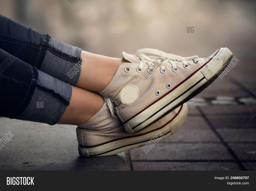

In [ ]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json
from fastdownload import download_url

download_url(search_images('sneakers shoes photos on legs', max_images=1)[0], 'shoes.jpg', show_progress=False)
Image.open('shoes.jpg').to_thumb(256,256)

In [ ]:
# Download Oxford Pets dataset
path = untar_data(URLs.PETS)
path_img = path/"images"
path_lbl = path/"annotations"/"trimaps"

In [ ]:
from pathlib import Path

# List all mask files
mask_files = list((path/"annotations"/"trimaps").iterdir())
print(f"Found {len(mask_files)} mask files.")
print("First 5 mask files:")
for f in mask_files[:5]:
    print(f.name)

Found 14780 mask files.
First 5 mask files:
Persian_173.png
newfoundland_161.png
american_bulldog_134.png
Sphynx_132.png
newfoundland_57.png


In [ ]:
def label_func(fn): return path_lbl/f'{fn.stem}.png'

In [ ]:
# Filter images that have corresponding masks
def get_valid_images():
    files = get_image_files(path_img)
    return [f for f in files if (path_lbl/f'{f.stem}.png').exists()]

# Check number of valid images
valid_fnames = get_valid_images()
print(f"Found {len(valid_fnames)} images with matching masks.")

Found 7390 images with matching masks.


In [ ]:
breeds = sorted({f.name.split('_')[0] for f in get_image_files(path/'images')})

# Oxford cat breeds (from paper)
cat_breeds = ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair',
              'Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue',
              'Siamese','Sphynx']


In [ ]:
def is_cat(fn):
    breed = fn.name.split('_')[0]
    return breed in cat_breeds


In [ ]:
class PetMask(PILMask):
    def __new__(cls, fn):
        mask = np.array(PILMask.create(fn))
        mask[mask == 3] = 0  # background
        mask[mask == 1] = 1  # foreground (temp value)
        mask[mask == 2] = 1  # foreground (temp value)

        # Check if it's a cat or dog
        image_fn = path_img/fn.name.replace('_mask', '')
        if is_cat(image_fn):
            mask[mask == 1] = 1  # cat
        else:
            mask[mask == 1] = 2  # dog

        return PILMask.create(mask)


In [ ]:
codes = ['none', 'cat', 'dog']  # class names

pets = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=codes)),
    get_items=get_valid_images,
    get_y=lambda o: PetMask(label_func(o)),
    splitter=RandomSplitter(seed=42),
    item_tfms=Resize((224, 224)),
    #batch_tfms=Normalize.from_stats(*imagenet_stats)
)

dls = pets.dataloaders(path_img, bs=8)
dls.show_batch(max_n=6, figsize=(10, 6))


TypeError: get_valid_images() takes 0 positional arguments but 1 was given

In [ ]:
dls = SegmentationDataLoaders.from_label_func(
    path=path,
    fnames=valid_fnames,
    label_func=label_func,
    codes=[1, 2, 3],
    bs=8,
    item_tfms=Resize((224, 224))
)

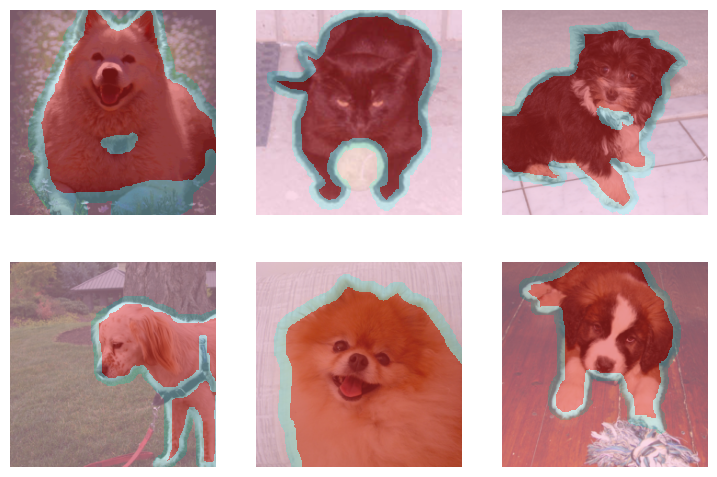

In [ ]:
dls.show_batch(max_n=6)

In [ ]:
# Create the Learner
learn = unet_learner(dls, resnet34)
learn.fine_tune(3)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# View results
learn.show_results()

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)